<a href="https://colab.research.google.com/github/Ulugbek9403/ml_edu/blob/master/notebooks/40_NB_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Работа с текстом

> 🚀 В этой практике нам понадобятся: `numpy==1.26.4, pandas==2.2.2, scikit-learn==1.4.2, matplotlib==3.8.4, seaborn==0.13.2, nltk==3.8.1, scipy==1.13.0`

> 🚀 Установить вы их можете с помощью команды: `%pip install numpy==1.26.4 pandas==2.2.2 scikit-learn==1.4.2 matplotlib==3.8.4 seaborn==0.13.2 nltk==3.8.1 scipy==1.13.0`


## Содержание

* [BOW](#BOW)
* [TF-IDF](#TF-IDF)
* [Байесовский классификатор](#Байесовский-классификатор)
* [Применяем инструменты!](#Применяем-инструменты)
* [Предобработка данных](#Предобработка-данных)
* [Больше инструментов!](#Больше-инструментов)
* [Задачи](#Задачи)
* [Вопросы для закрепления](#Вопросы-для-закрепления)
* [Полезные ссылки](#Полезные-ссылки)


До этого мы работали с численными данными или категориями, которые были представлены строками.

Строки мы научились кодировать, но что, если данные - это не просто строка или число, а осмысленный текст (заявка пользователей, письмо, комментарий на сайте, отзыв). Что нам тогда делать?

Для этого мы начнём со знакомства с методами кодирования текста в числовые векторы, а затем  посмотрим как дополнительная обработка данных может помочь улучшить результаты работы.

In [1]:
# Импорт необходимых модулей
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
TEXT_COLOR = "black"

plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["text.color"] = TEXT_COLOR
plt.rcParams["font.size"] = 14
plt.rcParams["lines.markersize"] = 15
plt.rcParams["axes.labelcolor"] = TEXT_COLOR
plt.rcParams["xtick.color"] = TEXT_COLOR
plt.rcParams["ytick.color"] = TEXT_COLOR

# Зафиксируем состояние случайных чисел
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## BOW

Начнем с самого базового метода работы с данными и для этого зададимся простым набором текстов:
- "Пирожок - это лишь пирожок!"
- "Пирог не кушать, пирожок - можно."
- "Я сегодня ходил в кино и поел пирог!"

Так, данные мы видим, это три предложения (три примера в данных), и что нам делать с ними дальше, если в будущем мы увидим одну из колонок текстового формата?

Самым простым подходом является метод **Bag Of Words**. Суть его заключается в том, что мы составляем список всех возможных слов из всех текстов (**словарь**/**корпус**) в обучающей выборке. После этого мы можем сформировать числовую матрицу, в которой строки - это тексты набора данных, а колонки - слова из словаря.

Сам подход, когда мы преобразуем что-то в числовой вектор фиксированной длины называется **векторизация**. То есть мы делаем преобразование данных неопределённой длины в вектор фиксированной длины, с которым модель уже может сама работать.

Посмотрим:

In [2]:
# Здесь специально сделана некоторая предобработка текстов,
#   которая обычно делается в рамках подготовки,
#   поэтому не смотрите на отсутсвие знаков предпинания и необычный формат слов
texts_dataset = [
    "пирожок это лишь пирожок",
    "пирог не кушать пирожок можно",
    "сегодня ходил кино поел пирог"
]

corpus = set()
# Для начала составим словарь
for text in texts_dataset:
    tokens = text.split(" ")
    corpus.update(tokens)

corpus = list(corpus)
print(f"Corpus: {corpus}")

Corpus: ['не', 'пирожок', 'кушать', 'пирог', 'лишь', 'это', 'сегодня', 'ходил', 'кино', 'поел', 'можно']


In [3]:
# После составления корпуса мы можем составить матрицу попаданий
samples_count = len(texts_dataset)
corpus_len = len(corpus)
X_data = np.zeros((samples_count, corpus_len), dtype=int)

for i_sample, text in enumerate(texts_dataset):
    tokens = text.split(" ")
    for token in tokens:
        token_index = corpus.index(token)
        X_data[i_sample, token_index] += 1

# Для лучшего представления составим DataFrame
X_df = pd.DataFrame(X_data, columns=corpus)
X_df["_texts"] = texts_dataset

X_df

,не,пирожок,кушать,пирог,лишь,это,сегодня,ходил,кино,поел,можно,_texts
0,0,2,0,0,1,1,0,0,0,0,0,пирожок это лишь пирожок
1,1,1,1,1,0,0,0,0,0,0,1,пирог не кушать пирожок можно
2,0,0,0,1,0,0,1,1,1,1,0,сегодня ходил кино поел пирог


Отлично! Теперь вне зависимости от длины текста, мы для каждого текста имеем закодированное представление в виде числового вектора! Каждый текст превращается в вектор длиной 11 элементов. То, что надо для модели!

Только есть два момента:
1. Значения в векторах дискретны и могут бесконечно расти, если одно и то же слово в конкретном тексте встречается 10 раз;
2. Теряется порядок слов.

Что же делать с порядком слов?

Мы можем вместо разовых слов проверять ещё и комбинации слов, например *good movie*, *did not* и другие.

Комбинации из двух слов называются **биграммы**, из трех - **триграммы**, и так общее название - **n-граммы** (**n-grams**). Это позволяет учитывать порядок в словах, а также ещё и очень сильно расширяет словарь!

> 🤓 В терминологии обработки текста атомарные единицы обработки называются **токены**. Часто под токенами понимаются отдельные слова в предложениях. Не исключением является и возможность назвать токеном целое предложение, но бывает такое в отдельных ситуациях обработки. Самая простая (но не самая лучшая) токенизация (разбиение текста на токены) - сплит по пробелам, это мы и сделали!

Вроде и вектора можно нормировать, взять каждый вектор и поделить на длину по L2 или L1 нормам, но даже так, просто подсчёт, как часто встречается слово в конкретном тексте, не отражает реальной значимости слова.

> ⚠️ Всё из-за того, что мы просто подсчитываем частоту слов в каждом тексте, но ведь важно ещё понимать, как часто слово встречается во всех текстах. Давайте посмотрим, что если мы имеем датасет на строительную тематику и в каждом тексте будет встречаться слово "строитель". В результате кодирования BOW подходом, на месте слова строитель в векторе всегда будет стоять единица. Таким образом, становится понятно, что это слово совсем незначимое, ведь оно есть везде и смысла его учитывать нет, но словарь это всё равно расширяет!

По сути подход BOW - отличный вариант, когда тексты небольшие и корпусы (словари) получаются маленькими.

**Основной проблемой** этого подхода является количество признаков в матрице (то есть размер словаря), которые летят на вход модели, и невозможность учесть важность слов среди всех текстов. Давайте рассмотрим другой подход, чуть сложнее, но он стоит того!

## TF-IDF


Название **TF-IDF** формируется из следующих названий:
- TF (term frequency) - отношение числа вхождений слова в тексте к числу слов в тексте;
- IDF (inverse document frequency) - логарифм количества текстов к количеству текстов с этим словом.

> Если пока формулировки не очень понятны - не беда. Дальше всё рассмотрим более подробно!

Результирующий показатель формируется из умножения значений TF на IDF для каждого интересующего слова. То есть, показатель $TFIDF = TF * IDF$.

Давайте попробуем разобраться в подходе! Наша задача - вычислить два показателя (TF и IDF) и после этого умножить их.

По сути мы уже создавали вектора в формате TF, когда для каждого слова рассчитывали сколько раз он попадается в каждом тексте к общему числу слов в этом тексте. Можно сказать, что нормированный BOW - это TF!

Давайте для примера рассчитаем TF-IDF для слова пирожок в наборе текстов:
- "Пирожок - это лишь пирожок!"
- "Пирог не кушать, пирожок - можно."
- "Я сегодня ходил в кино и поел пирог!"

$$
TF(word) = W(word) / N;
$$
где $W$ - количество упоминаний слова в тексте, $N$ - количество слов в тексте.

Для нашего случая получается по каждому тексту (нижний индекс):
$$
TF_1(пирожок) = 2 / 4 = 0.5; \\
TF_2(пирожок) = 1 / 5 = 0.2; \\
TF_3(пирожок) = 0 / 8 = 0; \\
$$

Теперь остаётся понять, как рассчитывать IDF. По сути, обратная частота документов - это сколько мы имеем текстов со словом по отношению к количеству текстов, только наоборот! Он показывает, в скольки текстах упоминается это слово.

$$
IDF(word) = log(M / T(word));
$$
где $T$ - количество текстов с этим словом в наборе данных, $M$ - количество текстов в наборе данных.

А значит для нас:
$$
IDF(пирожок) = log(3/2) = 0.176;
$$

Итого:
$$
TFIDF_1(пирожок) = 0.5 * 0.176 = 0.088; \\
TFIDF_2(пирожок) = 0.2 * 0.176 = 0.035; \\
TFIDF_3(пирожок) = 0 * 0.176 = 0; \\
$$

Вот такая математика! Но для чего это нужно? У нас же уже есть отличный BOW с нормированием.

IDF на самом деле делает очень важную вещь - помимо того, что мы оцениваем с помощью TF, насколько "важно" слово в отдельных текстах, с помощью IDF мы ещё и устраиваем нормирование с уточнением, насколько слово важно во всех текстах, так сказать, тематическое нормирование. Но не нужно сильно ориентироваться на "важно", тут скорее играет большую роль тот факт, что каждое слово имеет дополнительную характеристику, что сделает вектор более уникальным.

Давайте посмотрим на примере, как работает TF-IDF в рамках инструмента из фреймворка `sklearn` - [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    # Ограничение максимального кол-ва признаков (размера выходного вектора)
    #   None -> не ограничено, вычисляется из данных
    max_features=None
)

X_data = [
    "Пирожок - это лишь пирожок!",
    "Пирог не кушать, пирожок - можно.",
    "Я сегодня ходил в кино и поел пирог!"
]

X_data_vec = vectorizer.fit_transform(X_data)
# Отобразим векторизированное представление (кол-во данных, кол-во фич)
print(X_data_vec.shape)

(3, 11)


In [5]:
# Мы можем проверить корпус, который сформировался при генерации
corpus = vectorizer.get_feature_names_out()
corpus

array(['кино', 'кушать', 'лишь', 'можно', 'не', 'пирог', 'пирожок',
       'поел', 'сегодня', 'ходил', 'это'], dtype=object)

In [6]:
# Посмотрим на IDF значения корпуса
dict(zip(corpus, vectorizer.idf_))

{'кино': 1.6931471805599454,
 'кушать': 1.6931471805599454,
 'лишь': 1.6931471805599454,
 'можно': 1.6931471805599454,
 'не': 1.6931471805599454,
 'пирог': 1.2876820724517808,
 'пирожок': 1.2876820724517808,
 'поел': 1.6931471805599454,
 'сегодня': 1.6931471805599454,
 'ходил': 1.6931471805599454,
 'это': 1.6931471805599454}

In [7]:
df = pd.DataFrame(X_data_vec.todense(), columns = corpus)
df["_texts"] = X_data

df

,кино,кушать,лишь,можно,не,пирог,пирожок,поел,сегодня,ходил,это,_texts
0,0.000000,0.000000,0.481482,0.000000,0.000000,0.000000,0.732359,0.000000,0.000000,0.000000,0.481482,Пирожок - это лишь пирожок!
1,0.000000,0.490479,0.000000,0.490479,0.490479,0.373022,0.373022,0.000000,0.000000,0.000000,0.000000,"Пирог не кушать, пирожок - можно."
2,0.467351,0.000000,0.000000,0.000000,0.000000,0.355432,0.000000,0.467351,0.467351,0.467351,0.000000,Я сегодня ходил в кино и поел пирог!


Можно заметить, что численные значения отличаются от наших расчётов. Всё верно, так как внутренняя формула для расчёта немного отличается от той, что мы рассмотрели. Но не так важно получить конкретные числа (до тех пор, пока мы не хотим реализовать свой TF-IDF трансформер), как понять, что каждый текст представлен в виде численного вектора, который может быть подан на вход модели!

> Ещё обратите внимание, что трансформер сам делает некоторую предобработку: и слова, в которых всего одна буква - исключены из корпуса.

В результате из-за того, что помимо частоты слова в конкретном тексте, мы оцениваем ещё и насколько часто слово встречается среди текстов, векторы отличаются сильнее, что нам и нужно! По сути нам не так важны значения векторов, нежели их различия в значениях между собой, чтобы модель понимала отличия и вытаскивала информацию из этого!

## Байесовский классификатор

Мы уже знаем различные модели, но специфика данных в данном случае такая: они кодируются с частотой появления в текстах и, как результат, матрица данных имеет очень много фич (столбцов). Не нужно говорить, что для деревьев такой случай не очень подходит из-за количества фич, а линейная регрессия может оказаться недостаточной, поэтому мы познакомимся с подходом, который основывается на теореме Байеса и хорошо работает с закодированными данными в виде частот появлений.

Напомним, что теорема выглядит так:
$$
P(A|B) = \frac{P(B|A)P(A)}{P(B)}
$$

Здесь расшифровка следующая:
$P(A|B)$ - вероятность $A$ при истинности $B$;
$P(B|A)$ - вероятность $B$ при истинности $A$;
$P(A)$ - априорная вероятность того, что $A$ истинно;
$P(B)$ - априорная вероятность того, что $B$ истинно.

Сложно? На сегодняшний день очень много статей в интернете, объясняющих теорему, а мы будем сразу применять нашу теорему к данным для классификации!

Для примера возьмём следующие данные:

In [8]:
df = pd.DataFrame({
    "x1": [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2],
    "x2": ["A", "B", "B", "B", "C", "A", "A", "C", "A", "A", "C", "B", "B", "C", "C"],
    "y": [0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]
})

df

,x1,x2,y
0,0,A,0
1,0,B,0
2,0,B,1
3,0,B,1
4,0,C,0
5,1,A,0
6,1,A,1
7,1,C,1
8,1,A,1
9,1,A,0


Давайте попробуем с помощью байесовской теоремы определить, к какому классу принадлежит новая запись $X_{new}$ со значениями $x_1$ и $x_2$ равными $[2, C]$?

По сути нашей задачей является определение вероятностей $P(y=1|X=X_{new})$ и $P(y=0|X=X_{new})$. Первая вероятность $P(y=1|X=X_{new})$ - это вероятность того, что новая запись принадлежит классу 1 (то есть вероятность выбора класса 1 при условии появления данных $X_{new}$). Вторая вероятность $P(y=0|X=X_{new})$ - это вероятность классифицировать новую запись как класс 0 (аналогично). Какая вероятность будет больше - тот класс и выберем!

Теперь распишем формулы:
$$
P(y=1|X=X_{new}) = \frac{P(X=X_{new}|y=1)P(y=1)}{P(X=X_{new})} \\
P(y=0|X=X_{new}) = \frac{P(X=X_{new}|y=0)P(y=0)}{P(X=X_{new})} \\
$$

По сути, из-за того, что знаменатели одинаковые, то нам нужно всего-то сравнить числители! Не будем усложнять себе жизнь, надо определить всего-то 4 показателя:
- $P(y=0)$;
- $P(y=1)$;
- $P(X=X_{new}|y=0)$;
- $P(X=X_{new}|y=1)$.

Начнём с первых двух, это априорные вероятности, то есть, нам просто нужно определить, насколько вероятно на основе данных получить запись с классом $y=0$ или $y=1$. Как это сделать? Поделить количество записей класса на общее количество записей!

In [9]:
df["y"].value_counts()

,count
y,
1,8
0,7


Вот так мы получили количество записей классов, а значит можем рассчитать априорные вероятности:
$$
P(y=0) = \frac{7}{15}, P(y=1) = \frac{8}{15}
$$

Не сложно, не так ли? А что нам делать с остальными двумя? Тут немного сложнее, нам нужно рассчитать вероятности получения определённых значений фич при условии, что выбран конкретный класс. То есть, чтобы посчитать $P(X=X_{new}|y=1)$ для новой записи $X_{new} = [2, C]$, нам нужно раскрыть это выражение в виде $P(x_1=2|y=1)*P(x_2=C|y=1)$. Аналогично для другого класса. Итого, мы получаем:
$$
P(X=X_{new}|y=1) = P(x_1=2|y=1)*P(x_2=C|y=1) \\
P(X=X_{new}|y=0) = P(x_1=2|y=0)*P(x_2=C|y=0) \\
$$

> Тут по сути раскрытие $P(X) \rightarrow P(x_1)*P(x_2)$, так как вектор X состоит из двух компонент.

Давайте посмотрим, какие показатели нам нужны для вероятностей:

In [10]:
df.loc[df["y"] == 1, "x1"].value_counts()

,count
x1,
1,3
2,3
0,2


Таакс, мы можем рассчитать нашу первую вероятность, по сути поделив количество записей, в которых $x_1$ равен 2 и эти записи принадлежат классу $y = 1$ на общее количество записей этого класса:
$$
P(x_1=2|y=1) = \frac{3}{8}
$$

По аналогии считаем остальные показатели:

In [11]:
df.loc[df["y"] == 1, "x2"].value_counts()

,count
x2,
B,4
A,2
C,2


In [12]:
df.loc[df["y"] == 0, "x1"].value_counts()

,count
x1,
0,3
1,2
2,2


In [13]:
df.loc[df["y"] == 0, "x2"].value_counts()

,count
x2,
A,3
C,3
B,1


Итого получаем:
$$
P(x_1=2|y=1) = \frac{3}{8},
P(x_2=С|y=1) = \frac{2}{8} \\
P(x_1=2|y=0) = \frac{2}{7},
P(x_2=С|y=0) = \frac{3}{7} \\
$$

И считаем наши вероятности:
$$
P(y=1|X=X_{new}) = P(X=X_{new}|y=1)P(y=1) = \frac{3}{8} * \frac{2}{8} * \frac{8}{15} = \frac{1}{20} \\
P(y=0|X=X_{new}) = P(X=X_{new}|y=0)P(y=0) = \frac{2}{7} * \frac{3}{7} * \frac{7}{15} = \frac{2}{35}
$$

Так как $\frac{1}{20} < \frac{2}{35}$, то вывод - новая запись $X_{new} = [2, C]$ будет присвоена классу $y=0$!

Обратите внимание, классификатору для предсказания не потребовалось ничего, кроме данных и пары расчётов вероятностей. Именно поэтому данные модели хорошо справляются в задачами, в которых данные представлены в виде частот или количества повторений!

## Применяем инструменты!

Давайте попробуем применить новые изученные инструменты для обработки наших данных!

Для новой байесовской модели интерфейс работы ничем не отличается от того, к которому мы уже привыкли, вот класс [MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html).

Нашей сегодняшней задачей будет классификация новостей по категориям, для этого воспользуемся вот [этим набором данных](https://scikit-learn.org/stable/datasets/index.html#newsgroups-dataset).

Начнём с того, что посмотрим на наши данные:

In [14]:
from sklearn.datasets import fetch_20newsgroups

# В функции загрузки уже есть разделение на обучение/тест
#   воспользуемся этим на момент подготовки модели
# Для анализа лучше посмотреть на все данные
newsgroups_data = fetch_20newsgroups(subset="all", random_state=RANDOM_STATE)

In [15]:
print(newsgroups_data.keys())

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


In [16]:
# Посмотрим, какой у данных тип
data = newsgroups_data["data"]
targets = newsgroups_data["target"]
target_names = newsgroups_data["target_names"]

print(f"Data type:\t{type(data)}\n")
print(f"Target names:\n{target_names}\n")
print(f"Target data:\n{targets[:10]}")

Data type:	<class 'list'>

Target names:
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']

Target data:
[10  3 17  3  4 12  4 10 10 19]


Таакс, данные - это какой-то список и мы скоро узнаем какой именно, целевые переменные - индексы категорий. Посмотрим на пример данных:

In [17]:
print(data[0])
print("--------------")
print(f"Target: {target_names[targets[0]]}")

From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>
Subject: Pens fans reactions
Organization: Post Office, Carnegie Mellon, Pittsburgh, PA
Lines: 12
NNTP-Posting-Host: po4.andrew.cmu.edu



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!


--------------
Target: rec.sport.hockey


Как видим, данные представляют собой список текстов, поэтому предобработка будет связана с анализом и обработкой текстовой информациий.

Теперь берём подготовленные выборки и попробуем построить baseline на основе имеющихся данных.

In [18]:
# Подгрузим данные
newsgroups_train = fetch_20newsgroups(
    subset="train", random_state=RANDOM_STATE)
newsgroups_test = fetch_20newsgroups(
    subset="test", random_state=RANDOM_STATE)

X_train = newsgroups_train["data"]
y_train = newsgroups_train["target"]

X_test = newsgroups_test["data"]
y_test = newsgroups_test["target"]

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# Без всяких предобработок кидаем, что есть в трансформацию
vectorizer = TfidfVectorizer()

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

nb_clf = MultinomialNB()
nb_clf.fit(X_train_vec, y_train)

y_pred = nb_clf.predict(X_test_vec)

print(f"Train accuracy: {nb_clf.score(X_train_vec, y_train)}")

print(classification_report(y_test, y_pred))

Train accuracy: 0.9326498143892522
              precision    recall  f1-score   support

           0       0.80      0.52      0.63       319
           1       0.81      0.65      0.72       389
           2       0.82      0.65      0.73       394
           3       0.67      0.78      0.72       392
           4       0.86      0.77      0.81       385
           5       0.89      0.75      0.82       395
           6       0.93      0.69      0.80       390
           7       0.85      0.92      0.88       396
           8       0.94      0.93      0.93       398
           9       0.92      0.90      0.91       397
          10       0.89      0.97      0.93       399
          11       0.59      0.97      0.74       396
          12       0.84      0.60      0.70       393
          13       0.92      0.74      0.82       396
          14       0.84      0.89      0.87       394
          15       0.44      0.98      0.61       398
          16       0.64      0.94      0.76   

Вот так мы построили какую-то модель, которая немного переобучилась, судя по метрике точности.

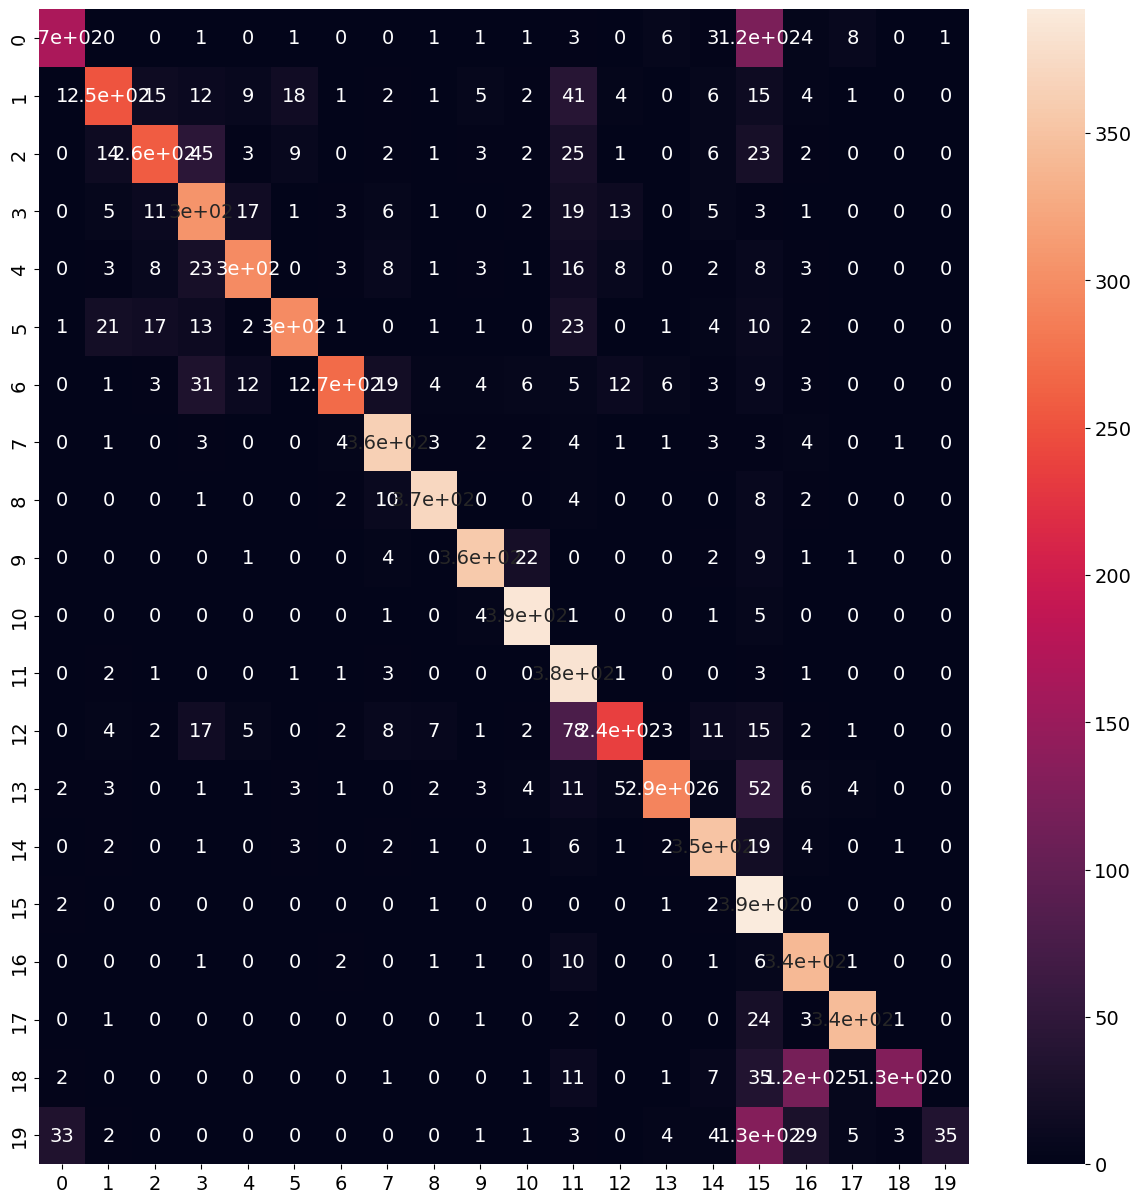

In [20]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True)
plt.show()

Как видно, модель путается в темах 18, 19.

В остальном, работает относительно неплохо для baseline решения.

Давайте посмотрим, как мы можем улучшить результат за счёт предобработки!

## Предобработка данных

Мы, конечно, увидели, что можно текст кинуть на работу модели просто прогнав через трансформацию, но работа с текстом имеет и свои подходы расширенного анализа и предобработки!

Рассмотрим некоторые основные из них!

При работе с текстом наиболее распространёнными практиками являются следующие способы предоработки:
- Приведение к нижнему регистру - позволяет работать с единой формой слов, при которой нет разницы в словах Hello и hello;
- Удаление пунктуации, стоп-слов и низкочастотных слов - позволяет акценитровать внимание на значимых словах;
- Токенизация - разбиение предложений на токены (слова, биграммы, триграммы, N-граммы);
- Стеммизация - удаление суффиксов слов: playing -> play, studied -> studi, один из методов нормализации;
- Лемматизация - приведение к лемме (нормальной форме): played -> play, тоже один из подходов нормализации;

> Насчёт паттернов (`re` ~ `RegularExpressions`) и того, как ими пользоваться есть хорошая [статья](https://tproger.ru/translations/regular-expression-python/).

Для реализации необходимого функционала воспользуемся фреймворком `nltk` и загрузкой необходимых данных через `nltk.download()`.

In [21]:
import nltk
# Скачиваем необходимые модули фреймворка nltk
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re
from string import punctuation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Теперь опробуем каждую из методик:

In [22]:
# Выберем текст для примера и посмотрим
sample_text = X_train[1]

print(sample_text)

From: guykuo@carson.u.washington.edu (Guy Kuo)
Subject: SI Clock Poll - Final Call
Summary: Final call for SI clock reports
Keywords: SI,acceleration,clock,upgrade
Article-I.D.: shelley.1qvfo9INNc3s
Organization: University of Washington
Lines: 11
NNTP-Posting-Host: carson.u.washington.edu

A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the next two days, so please add to the network
knowledge base if you have done the clock upgrade and haven't answered this
poll. Thanks.

Guy Kuo <guykuo@u.washington.edu>



In [23]:
# Проверим работу приведения к нижнему регистру
# Этот подход позволяет исключить различия слов Hello и hello,
#   так как по сути это одно и то же слово
sample_text = sample_text.lower()
print(sample_text)

from: guykuo@carson.u.washington.edu (guy kuo)
subject: si clock poll - final call
summary: final call for si clock reports
keywords: si,acceleration,clock,upgrade
article-i.d.: shelley.1qvfo9innc3s
organization: university of washington
lines: 11
nntp-posting-host: carson.u.washington.edu

a fair number of brave souls who upgraded their si clock oscillator have
shared their experiences for this poll. please send a brief message detailing
your experiences with the procedure. top speed attained, cpu rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

i will be summarizing in the next two days, so please add to the network
knowledge base if you have done the clock upgrade and haven't answered this
poll. thanks.

guy kuo <guykuo@u.washington.edu>



In [24]:
# Удаление пунктуации
# Более сложный анализ может учитывать пунктуацию, но для простых
#   случаев пунктуация исключается, чтобы оставить лишь слова
#   как основную информацию
punct_transl = str.maketrans("", "", punctuation)
sample_text = sample_text.translate(punct_transl)
print(sample_text)

from guykuocarsonuwashingtonedu guy kuo
subject si clock poll  final call
summary final call for si clock reports
keywords siaccelerationclockupgrade
articleid shelley1qvfo9innc3s
organization university of washington
lines 11
nntppostinghost carsonuwashingtonedu

a fair number of brave souls who upgraded their si clock oscillator have
shared their experiences for this poll please send a brief message detailing
your experiences with the procedure top speed attained cpu rated speed
add on cards and adapters heat sinks hour of usage per day floppy disk
functionality with 800 and 14 m floppies are especially requested

i will be summarizing in the next two days so please add to the network
knowledge base if you have done the clock upgrade and havent answered this
poll thanks

guy kuo guykuouwashingtonedu



In [25]:
# Удаление чисел
# Числа как правило редко повторяются, для простого подхода
#   достаточно удалить числа, так как это неповторяющаяся информация
sample_text = re.sub(r"\d+", "", sample_text)
print(sample_text)

from guykuocarsonuwashingtonedu guy kuo
subject si clock poll  final call
summary final call for si clock reports
keywords siaccelerationclockupgrade
articleid shelleyqvfoinncs
organization university of washington
lines 
nntppostinghost carsonuwashingtonedu

a fair number of brave souls who upgraded their si clock oscillator have
shared their experiences for this poll please send a brief message detailing
your experiences with the procedure top speed attained cpu rated speed
add on cards and adapters heat sinks hour of usage per day floppy disk
functionality with  and  m floppies are especially requested

i will be summarizing in the next two days so please add to the network
knowledge base if you have done the clock upgrade and havent answered this
poll thanks

guy kuo guykuouwashingtonedu



In [26]:
# Удаление повторяющихся пробелов
# Часто в текста делают кучу пробелов, переносов и отступов - они не несут информации
sample_text = re.sub(r"\s+", " ", sample_text)
print(sample_text)

from guykuocarsonuwashingtonedu guy kuo subject si clock poll final call summary final call for si clock reports keywords siaccelerationclockupgrade articleid shelleyqvfoinncs organization university of washington lines nntppostinghost carsonuwashingtonedu a fair number of brave souls who upgraded their si clock oscillator have shared their experiences for this poll please send a brief message detailing your experiences with the procedure top speed attained cpu rated speed add on cards and adapters heat sinks hour of usage per day floppy disk functionality with and m floppies are especially requested i will be summarizing in the next two days so please add to the network knowledge base if you have done the clock upgrade and havent answered this poll thanks guy kuo guykuouwashingtonedu 


In [29]:
# Токенизация - превращаем одну большую строку в массив токенов (в нашем случае слов)
# Под токенами могут пониматься не только слова, но и комбинации слов,
#   хотя для простого анализа - достаточно токенизировать до слов


In [30]:
# Удаляем стоп-слова, для начала посмотрим, что это за слова
stop_words = set(stopwords.words("english"))
print(stop_words)

{'too', 'all', 'y', "hasn't", "you're", 'until', 'we', 'themselves', 're', 'ma', 'again', 'each', 'up', 'then', 'that', 'should', "haven't", 'itself', 'if', 'as', 't', 'most', 'he', 'i', 'it', 'wouldn', 'out', 'had', 'himself', 'under', 'of', 'this', 'off', 'and', 'just', 'its', 'during', 'which', 'been', 'his', 'here', 'was', 'me', 'have', 'shan', "mightn't", 'the', 'over', 'but', 'at', 'has', 'weren', 'shouldn', "she's", 'such', 'after', "don't", 'o', 'she', 'about', 'haven', 'in', 'm', 'being', 'do', 'my', 'you', 'while', 'both', 'other', 'is', 'hadn', 'what', "weren't", 'these', 'were', 'couldn', 'didn', 'when', 'be', "it's", 'ours', 'against', 'who', 'needn', 'did', 'not', 'can', 'by', "doesn't", 'no', 'her', 'their', 've', 'ourselves', 'down', 'with', 'so', 'our', 'nor', 'him', "couldn't", 's', 'they', 'wasn', "wasn't", 'or', 'only', "that'll", 'through', 'any', 'between', 'very', 'isn', 'doing', "you'll", 'herself', 'why', 'now', 'once', "shouldn't", 'above', 'll', 'yourselves',

In [31]:
# Теперь фильтруем стоп-слова из наших токенов
word_tokens = [word for word in word_tokens if word not in stop_words]
print(word_tokens)

NameError: name 'word_tokens' is not defined

In [32]:
# Проводим лемматизацию - приводим к нормальной форме
wordnet_lemmatizer = WordNetLemmatizer()

word_tokens = [wordnet_lemmatizer.lemmatize(word) for word in word_tokens]
print(word_tokens)

NameError: name 'word_tokens' is not defined

In [33]:
# Чтобы лучше понять, как он работает - рассмотрим примеры:
print(wordnet_lemmatizer.lemmatize("bats"))
print(wordnet_lemmatizer.lemmatize("are"))  # Ууупс, тут не преобразовалось в be =(
print(wordnet_lemmatizer.lemmatize("feet"))

bat
are
foot


In [34]:
# А вот как работает стемминг - другой подход нормализации текста
stemmer = PorterStemmer()

print(stemmer.stem("bats"))
print(stemmer.stem("are"))  # Ууупс, тут не преобразовалось в be =(
print(stemmer.stem("feet"))
# Ещё примеров, чтобы лучше понять, что просто отрывать часть слова - не всегда хорошая идея
print(stemmer.stem("shortly"))
print(stemmer.stem("magnificence"))

bat
are
feet
shortli
magnific


In [35]:
# После этого нам нужно объединить токены обратно в единую строку
#   для будущего кодирования
processed_text = " ".join(word_tokens)
print(processed_text)

NameError: name 'word_tokens' is not defined

Как вы видите, каждый этап предобработки делает простую трансформацию данных, чтобы в конечном итоге привести к более стандартному виду без примесей и лишних выбросов. При этом один из последних этапов - лемматизация может иметь ошибки в работе. Аналогом лемматизации является стемминг, когда вместо приведения к нормальной форме мы отбрасывает окончание и суффикс. Выбор подхода остаётся за разработчиком и конкретной задачей.

> Альтернативными фреймворками для обработки текста являются фреймворки [spaCy](https://spacy.io/), [TextBlob](https://textblob.readthedocs.io/en/dev/), [Gensim](https://radimrehurek.com/gensim/), [pymorphy2](https://pymorphy2.readthedocs.io/en/stable/). Вы можете попробовать использовать их, так как каждый из них имеет свои плюсы и минусы.

## Больше инструментов!

Давайте опробуем аналогичные вещи, но с использованием другого инструмента, который имеет более широкую поддержку сегодня и более широкий набор языков - [spaCy](https://spacy.io/)!

Для примера будем  обрабатывать следующий текст:

*С другой стороны, новая модель организационной деятельности в значительной степени обусловливает важность системы массового участия. Равным образом, семантический разбор внешних противодействий играет определяющее значение для стандартных подходов. Ясность нашей позиции очевидна: внедрение современных методик предоставляет широкие возможности для модели развития.*

Начнём с того, что загрузим и импортируем требуемую модель под конкретный язык. Посмотреть доступные модели можно на [странице spaCy](https://spacy.io/usage/models).

In [36]:
%%bash
spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 41.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [37]:
import spacy
nlp = spacy.load("ru_core_news_sm")

Отлично, вот так просто загружается модель для работы с языком! Теперь давайте попробуем токенизировать текст - разбить на токены (слова).

> 🤓 Несмотря на кажущуюся очевидность операции токенизации, простой сплит по "пробелу" даёт не всегда ожидаемый результат, так как слова могут быть разделены дефисом, иметь в конце символы и т.д. Поэтому, современные инструменты могут за вас хорошо решить даже такую простую операцию!

In [38]:
text = "С другой стороны, новая модель организационной деятельности в значительной степени обусловливает важность системы массового участия. \
Равным образом, семантический разбор внешних противодействий играет определяющее значение для стандартных подходов. \
Ясность нашей позиции очевидна: внедрение современных методик предоставляет широкие возможности для модели развития."

text

'С другой стороны, новая модель организационной деятельности в значительной степени обусловливает важность системы массового участия. Равным образом, семантический разбор внешних противодействий играет определяющее значение для стандартных подходов. Ясность нашей позиции очевидна: внедрение современных методик предоставляет широкие возможности для модели развития.'

In [39]:
nlp = spacy.load("ru_core_news_sm")
doc = nlp(text)

for token in doc[:20]:
    print(token)

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


С
другой
стороны
,
новая
модель
организационной
деятельности
в
значительной
степени
обусловливает
важность
системы
массового
участия
.
Равным
образом
,


Как видите, токенизация сама смогла выделить пунктуацию в отдельные токены, чего не смог бы простой сплит!

Теперь давайте посмотрим, как нам произвести нормализацию текста. SpaCy подерживает только лемматизацию, поэтому для стемминга можно воспользоваться уже изученным подходом из nltk.

In [40]:
doc = nlp(text)

for token in doc[:20]:
    print(f"{token} -> {token.lemma_}")

С -> с
другой -> другой
стороны -> сторона
, -> ,
новая -> новый
модель -> модель
организационной -> организационный
деятельности -> деятельность
в -> в
значительной -> значительный
степени -> степень
обусловливает -> обусловливать
важность -> важность
системы -> система
массового -> массовый
участия -> участие
. -> .
Равным -> равный
образом -> образ
, -> ,


Отлично! Вот так просто делается лемматизация слов в spaCy, но что же насчёт стоп-слов?

Как и со стеммингом, список стоп-слов можно использовать из nltk:

In [41]:
stop_words = set(stopwords.words("russian"))
print(stop_words)

{'не', 'до', 'были', 'вам', 'после', 'ему', 'чего', 'через', 'надо', 'сам', 'во', 'между', 'тем', 'ни', 'впрочем', 'ней', 'этой', 'этого', 'у', 'ним', 'уже', 'них', 'об', 'в', 'нибудь', 'будет', 'при', 'вдруг', 'больше', 'иногда', 'какая', 'конечно', 'хоть', 'разве', 'даже', 'тогда', 'зачем', 'нее', 'перед', 'ничего', 'где', 'мы', 'ж', 'никогда', 'много', 'всех', 'если', 'из', 'такой', 'себя', 'лучше', 'а', 'хорошо', 'был', 'с', 'они', 'три', 'ты', 'почти', 'но', 'этот', 'было', 'будто', 'совсем', 'про', 'чтоб', 'без', 'бы', 'о', 'того', 'этом', 'всю', 'тебя', 'теперь', 'его', 'один', 'то', 'да', 'ли', 'так', 'себе', 'него', 'чуть', 'мне', 'что', 'мой', 'их', 'меня', 'им', 'была', 'на', 'нас', 'нельзя', 'ведь', 'потому', 'к', 'ее', 'вы', 'ну', 'все', 'сейчас', 'только', 'вас', 'над', 'эту', 'всегда', 'там', 'тоже', 'со', 'раз', 'эти', 'же', 'другой', 'есть', 'потом', 'всего', 'наконец', 'он', 'том', 'здесь', 'куда', 'уж', 'и', 'за', 'как', 'от', 'под', 'два', 'ей', 'еще', 'опять', 'кто

Такс, окей, тогда получается, что в nltk функционал даже шире, чем в spaCy? Тогда зачем же использовать spaCy и почему он такой популярный?

Ответ прост! То, что мы рассмотрели - это лишь малая часть той красоты, что может spaCy. Прибавьте к высокой скорости обработки поддержку огромного количества языков и ещё такие плюшки, как распознавание части речи! Представляете, и такое он может:

In [42]:
fmt = "{:>16} {:>10}"

print(fmt.format("Token", "POS"), "\n")
for token in doc[:20]:
   print(fmt.format(token.text, token.pos_))

           Token        POS 

               С        ADP
          другой        ADJ
         стороны       NOUN
               ,      PUNCT
           новая        ADJ
          модель       NOUN
 организационной        ADJ
    деятельности       NOUN
               в        ADP
    значительной        ADJ
         степени       NOUN
   обусловливает       VERB
        важность       NOUN
         системы       NOUN
       массового        ADJ
         участия       NOUN
               .      PUNCT
          Равным        ADJ
         образом       NOUN
               ,      PUNCT


Для нашего случая мы имеем:
- ADJ - прилагательное
- ADP - предлог
- NOUN - существительное
- VERB - глагол
- PUNCT - пунктуация

И ведь нам практически ничего не пришлось делать! Весь разбор был сделан передачей текста в **пайплайн** обработки текста (это в терминологии spaCy).

Вот такие интересные трюки и подходы можно применять, чтобы разобрать тексты, подготовить, обработать и в результате улучшить работу модели!

Теперь, когда мы рассмотрели, а вы поняли основные подходы, вы сможете сделать очень крутые вещи!

А пока, мы предлагаем вам попробовать свои силы в обработке текста и классификации на основе него на датасете с новостями.

## Задачи

Следующие задачки позволят вам самостоятельно опробовать работу моделей и попрактиковаться в применении изученных инструментов.

> 🔥 Не забывайте, что предобработку лучше заворачивать в класс, чтобы потом можно было его просто применять!

- Проведите анализ текстовых данных набора данных 20newsgroups;
- Постройте модель `MultinominalNB` с параметрами по-умолчанию и без предобработки текста, только векторизация (baseline);
- Добавьте предобработку текста, оцените работу модели;
- Отобразите CM и сделайте выводы, какие разделы путаются;
- Изучите влияние $\alpha$ байесовского классификатора (7 значений);
- Изучите влияние максимального количества признаков `TfidfVectorizer` (10 значений `max_features`);
- Оцените работу модели при различных значения `ngram_range` (варьируя верхний предел - от 1 до 3 включительно);
- Определите лучшую модель путём настройки гиперпараметров (по показателю `f1_macro`), отобразите CM и отчёт по классификации;
- Постройте модель случайного леса, определите лучшие гиперпараметры и сравните с моделью байесовского классификатора;
- Проанализируйте ошибки классификаторов и сделайте выводы;
- Удалите дополнительную информацию (используйте аргумент `remove` в функции `fetch_20newsgroups()` с указанием в качестве значения кортеж `("headers", "footers", "quotes")`) -> оцените работу лучшей модели (с переобучением на очищенном наборе данных);
- Определите новую лучшую модель (с учетом удаления доп.информации из текстов) путем настройки гиперпараметров (по показателю `f1_macro`);
- Отобразите CM и сделайте выводы, какие разделы путаются;

> CM = Confusion Matrix

## Вопросы для закрепления

А теперь пара вопросов, чтобы закрепить материал!

- За что отвечает параметр $\alpha$ в модели? Как значение влияет на показатели
метрик?
- В чём разница работы модели случайного леса и байесовского классификатора?
- Как повлияло удаление дополнительной информации из текстов? С чем это может быть связано?

## Полезные ссылки
* [Naive Bayes от StatQuest](https://www.youtube.com/watch?v=O2L2Uv9pdDA)
* [Naive Gaussian Bayes от StatQuest](https://www.youtube.com/watch?v=H3EjCKtlVog)
